<a href="https://colab.research.google.com/github/jan-kreischer/UZH_ML4NLP/blob/main/Project-03/ex03_cnn_jan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 3 - Language Identification (Reloaded and Convoluted)
## 1. Setup
### 1.1 Dependencies

In [1]:
!pip install talos

     |████████████████████████████████| 53 kB 1.0 MB/s 
     |████████████████████████████████| 9.8 MB 10.4 MB/s 
     |████████████████████████████████| 5.4 MB 53.1 MB/s 
     |████████████████████████████████| 51 kB 857 kB/s 
     |████████████████████████████████| 2.6 MB 41.5 MB/s 
  Created wheel for chances: filename=chances-0.1.9-py3-none-any.whl size=41609 sha256=de91746f328e758915bbac1f104694c942cf725d9190b0e0c33d7bfbdb2fdda5
  Stored in directory: /root/.cache/pip/wheels/f3/2e/7e/316f7da11ccf2195ff05e4a0186a4b5975be9bd0b0004198b6
  Created wheel for kerasplotlib: filename=kerasplotlib-0.1.6-py3-none-any.whl size=3603 sha256=ff0a92f906e5e8776ea564967a814d0f0233cd90fdaa99881f96a73f0a95dd6a
  Stored in directory: /root/.cache/pip/wheels/1c/b4/c8/d1533d85f7fc617e3201c3f41b79fe49ae9284c8fc4a5bd4b2
Successfully built chances kerasplotlib
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uni

In [2]:
!pip install demoji

     |████████████████████████████████| 42 kB 887 kB/s 


In [3]:
!pip install googletrans==4.0.0rc1

     |████████████████████████████████| 55 kB 2.5 MB/s 
     |████████████████████████████████| 1.3 MB 10.3 MB/s 
     |████████████████████████████████| 42 kB 1.6 MB/s 
     |████████████████████████████████| 65 kB 4.9 MB/s 
     |████████████████████████████████| 53 kB 2.9 MB/s 
  Created wheel for googletrans: filename=googletrans-4.0.0rc1-py3-none-any.whl size=17415 sha256=173d44bda481126ec1e94127f2e12e79638a00cb8fa6badd3f83af6ead2b8c50
  Stored in directory: /root/.cache/pip/wheels/43/34/00/4fe71786ea6d12314b29037620c36d857e5d104ac2748bf82a
Successfully built googletrans



### 1.2 Imports

In [4]:
import csv
import re
from io import StringIO
import requests
import string
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt  
from keras.preprocessing.text import Tokenizer
import numpy as np
import pandas as pd
from keras.models import Sequential
import warnings
from keras.layers import Embedding
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score
from keras.layers import Conv1D, GlobalMaxPooling1D, AveragePooling1D
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Activation
from keras import backend as K
from keras.callbacks import EarlyStopping
#from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical
import talos

#import talos
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 100)
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 1000

from googletrans import Translator
translator = Translator()

import csv
import re
import numpy as np

import pandas as pd
pd.set_option('display.max_rows', 200)  
pd.set_option('display.max_columns', 200)   
pd.set_option('display.width', 4000)

import torch

from io import StringIO
import requests
import matplotlib.pyplot as plt

import demoji

from sklearn.utils import resample
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

### 1.2 Environment

In [5]:
# Check if device supports CUDA interface
CUDA = torch.cuda.is_available()
# Make program run on gpu (cuda:0) if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu:0')
torch.cuda.set_device(device)
print('Using device:', device)

Using device: cuda:0


In [6]:
# Check and print information about available GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Nov  6 10:44:07 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    28W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
# Get GPU name
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-7ac3d541-a9a7-41f4-3201-12503ac09b2a)


In [8]:
# Check Memory
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


### 1.4 Constants

In [9]:
TARGET_COLUMN = 'label'
TWEET_COLUMN = 'tweet'
SAMPLE_THRESHOLD = 20
MAX_SEQ_LEN = 80

## 2. Data Acquisition

In [10]:
url_train = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vTOZ2rC82rhNsJduoyKYTsVeH6ukd7Bpxvxn_afOibn3R-eadZGXu82eCU9IRpl4CK_gefEGsYrA_oM/pub?gid=1863430984&single=true&output=tsv'
url_test = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vT-KNR9nuYatLkSbzSRgpz6Ku1n4TN4w6kKmFLkA6QJHTfQzmX0puBsLF7PAAQJQAxUpgruDd_RRgK7/pub?gid=417546901&single=true&output=tsv'

In [11]:
def load_dataset(url):
  r = requests.get(url)
  data = r.content.decode('utf8')
  df = pd.read_csv(StringIO(data), sep='\t')
  df.columns = ['tweet', 'label']
  return df

In [12]:
df_train = load_dataset(url_train)
df_test = load_dataset(url_test)

In [13]:
dataset = pd.concat([df_train, df_test], axis=0) # Merge into one dataset for the pre-processing

In [14]:
print("The length of the combined dataset is {0} training samples + {1} test samples = {2} samples".format(len(df_train), len(df_test), len(dataset)))

The length of the combined dataset is 52675 training samples + 13279 test samples = 65954 samples


In [15]:
dataset = dataset.sample(frac=1).reset_index(drop=True) # Randomly shuffle the data

In [16]:
dataset.head(10) # Show some sample tweets

,tweet,label
0,دعاء السجود:سبحان ذي الجبروت والملكوت والكبريا...,ar
1,@royal_afif berbuka dengan bersederhana saja. ...,id
2,#appydeals Free offer: Learn The French Alphab...,en
3,Good morning to all of you less-intelligent-th...,en
4,Let the family of the victims have them to do....,en
5,talk to me I don't want to talk to Remington a...,en
6,Manifestor - Beyond Illusions by Trance - http...,en
7,Adam wouldn't share his Cheerios. 🙊✌️😊 #TooCut...,en
8,【Enter 横浜関内】に行きたい♪ここにも素敵なお店⇒http://t.co/q8hHgZ...,ja
9,Conozco la razón que hace doler tú corashon,es


## 3. Data Exploration

In [17]:
def data_exploration(df):
  n_labels = len(np.unique(df["label"]))
  df = df.sort_values('label')
  print("Dataset contains the columns: {}".format(list(df.keys())))
  print("with a total of {} observations".format(len(df)))
  print("and {} different possible labels.".format(n_labels))
  print("The unique labels are {}".format(df["label"].unique()))
  plt.figure(figsize=(15, 3))
  plt.hist(df["label"], bins=n_labels)
  plt.xticks(rotation=90)
  plt.yscale("log")
  plt.xlabel("Language")
  plt.ylabel("#Occurences")
  plt.show()

In [18]:
# This function checks which lanugages occur in the full dataset less than 'SAMPLE_THRESHOLD' times.
# These languages are then returned as the list of underrepresented languages
def get_underrepresented_languages(df, target_column, sample_threshold):
    df = df.groupby(target_column).size().to_frame().reset_index(drop=False).rename(columns={0: 'occurences'})
    underrepresented_languages = list(df[df['occurences'] < SAMPLE_THRESHOLD][target_column])
    return underrepresented_languages

In [19]:
def print_number_of_underrepresented_languages(df, target_column, sample_threshold):
  underrepresented_languages = get_underrepresented_languages(df, target_column, sample_threshold)
  print("There are {} languages in this data set with less then {} samples.".format(len(underrepresented_languages), sample_threshold))

Dataset contains the columns: ['tweet', 'label']
with a total of 65954 observations
and 78 different possible labels.
The unique labels are ['ar' 'ar_LATN' 'az' 'bg' 'bn' 'bs' 'ca' 'cs' 'cy' 'da' 'de' 'dv' 'el'
 'en' 'es' 'et' 'eu' 'fa' 'fi' 'fr' 'gl' 'ha' 'he' 'hi' 'hi-Latn' 'hr'
 'ht' 'hu' 'hy' 'id' 'is' 'it' 'ja' 'ja_LATN' 'jv' 'km' 'ko' 'ko_LATN'
 'la' 'lv' 'mk' 'mn' 'mr' 'ms' 'ne' 'nl' 'no' 'pl' 'ps' 'ps_LATN' 'pt'
 'ro' 'ru' 'si' 'sk' 'sl' 'sq' 'sr' 'su' 'sv' 'sw' 'ta' 'ta_LATN' 'th'
 'tl' 'tn' 'tr' 'uk' 'und' 'ur' 'ur_LATN' 'vi' 'wo' 'xh' 'yo' 'zh-CN'
 'zh-TW' 'zu']


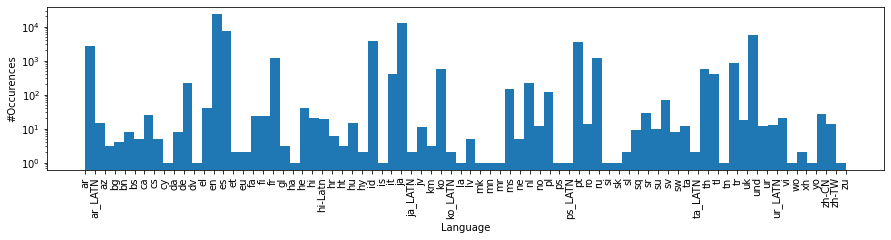

In [20]:
data_exploration(dataset)

In [21]:
print_number_of_underrepresented_languages(dataset, TARGET_COLUMN, SAMPLE_THRESHOLD)

There are 50 languages in this data set with less then 20 samples.


In [22]:
# Display all languages and their absolute number off occurences in descending order
language_count=dataset[TARGET_COLUMN].value_counts().reset_index()
language_count
df = pd.DataFrame(language_count)
df.columns = ['language', 'occurences']
df

,language,occurences
0,en,23266
1,ja,12899
2,es,7406
3,und,5766
4,id,3823
5,pt,3577
6,ar,2728
7,ru,1221
8,fr,1170
9,tr,843


## 4. Text Cleaning

This is generally a good idea as many text classification tools rely on counting the occurrences of words. If both upper and lower case versions of the same word are found in the text then the algorithm will count them as different words even though the meaning is the same. Of course this does mean that where the capitalised versions of a word exists, that does have a different meaning. For example the company Apple vs the fruit apple. This could result in poorer performance for some data sets. This is one area of NLP where you may try different methods to see how they affect the overall performance of the model. We decided to transform our corpus into lowercase, since the case wont have
a big influence on the language classification performance

In [23]:
def remove_all_emojis(text):
  dem = demoji.findall(text)
  for item in dem.keys():
    text = text.replace(item, '')
  return text

In [24]:
def clean_data(df, column):
    df = df.copy(deep=True) # Make deep copy of tweets
    df[column] = df[column].str.lower() # Transform into all lowercase
    
    patterns = []
    retweet_pattern = '^RT'
    patterns.append(retweet_pattern)
    xml_pattern = '&\S+;'
    patterns.append(xml_pattern)
    hashtag_pattern = '#[A-Za-z0-9_]+'
    patterns.append(hashtag_pattern)
    twitter_mention_pattern = '@[A-Za-z0-9_]+'
    patterns.append(twitter_mention_pattern)
    http_pattern = 'http\S+'
    patterns.append(http_pattern)
    www_pattern = 'www\S+'
    patterns.append(www_pattern)
    tab_pattern = '\t'
    patterns.append(tab_pattern)
    punctuation_pattern = '[!"#$%&\\()*+,-./:;<=>?@\[\]^_`\'{}~]+'
    patterns.append(punctuation_pattern)
    numeric_pattern = '[0-9]+'
    patterns.append(numeric_pattern)
    regex = "|".join(patterns)

    #df[column] = df[column].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem)) 
    df[column] = df[column].apply(lambda elem: re.sub(r"{}".format(regex), "", elem))
    df[column] = df[column].apply(remove_all_emojis)
    
    return df

In [25]:
# Now we want to find out which special characters need to be removed from tweets in order to make the prediction better.
# We go over the printed list an not down the symbold which are not needed for language identification.
# These will be removed in a later step.
languages = list(np.unique(dataset[TARGET_COLUMN]))
for language in languages:
  localized_tweets = dataset[dataset[TARGET_COLUMN] == language]
  # Clean and compare them
  cleaned_localized_tweets = clean_data(localized_tweets, TWEET_COLUMN)
  comparison_view = pd.concat([localized_tweets.drop([TARGET_COLUMN], axis=1), cleaned_localized_tweets], axis=1)
  print(comparison_view.head(5))
  #print(localized_tweets.head(5))
  print("---")

# Symbols like @<mention>, #, http://link !, numeric values (e.g 16000), " do not help for language identification.

                                                tweet                                              tweet label
0   دعاء السجود:سبحان ذي الجبروت والملكوت والكبريا...  دعاء السجودسبحان ذي الجبروت والملكوت والكبرياء...    ar
14  اللهم إني أعوذ بك من شر ما عملت، ومن شر ما لم ...  اللهم إني أعوذ بك من شر ما عملت، ومن شر ما لم ...    ar
15  سبحان الذي إذا ذكرته ذكرك ،   وإن شكرته زادك ,...  سبحان الذي إذا ذكرته ذكرك ،   وإن شكرته زادك  ...    ar
50  اللهم نقني من الذنوب والخطايا كما ينقى الثوب ا...  اللهم نقني من الذنوب والخطايا كما ينقى الثوب ا...    ar
57  @1KsaNews1 حسن صادق وقد خسر الكثير بسبب صدقه ة...   حسن صادق وقد خسر الكثير بسبب صدقه ةانت وامثال...    ar
---
                                    tweet                           tweet    label
4464                        kalmooni ya5e                    kalmooni yae  ar_LATN
5372                 ya allah ya allah x)             ya allah ya allah x  ar_LATN
5605              Ya rab tekhlas hel game         ya rab tekhlas hel game  ar_LAT

In [26]:
cleaned_dataset = clean_data(dataset, TWEET_COLUMN)

In [27]:
# Check that the dataset does not contain null values
cleaned_dataset.isnull().values.any() 

False

## 5.Data Augmentation
We consider languages which have less then 20 sample tweets in the dataset as infrequent. You can either remove these infrequent languages or use augmentation or upsampling techniques to increase the language frequency.
We decided to use back translation in order to keep infrequent languages but increase their frequency.


In [28]:
def back_translation(df,target_languages=['en']):
  translated_data = pd.DataFrame(columns={TWEET_COLUMN, TARGET_COLUMN})
  for target_language in target_languages:
    for index, row in df.iterrows():
      try:
        tweet = row[TWEET_COLUMN]
        source_language = row[TARGET_COLUMN]
        translated_data=translated_data.append({'tweet': translator.translate(translator.translate(tweet, dest=target_language).text, dest=source_language).text, 'label': source_language}, ignore_index=True)
      except Exception as e:
        print(e)
        pass
  return translated_data

In [29]:
print_number_of_underrepresented_languages(cleaned_dataset, TARGET_COLUMN, SAMPLE_THRESHOLD)

There are 50 languages in this data set with less then 20 samples.


In [30]:
underrepresented_languages = get_underrepresented_languages(cleaned_dataset, TARGET_COLUMN, SAMPLE_THRESHOLD)
print(underrepresented_languages)

['ar_LATN', 'az', 'bg', 'bn', 'bs', 'cs', 'cy', 'da', 'dv', 'et', 'eu', 'gl', 'ha', 'hi-Latn', 'hr', 'ht', 'hu', 'hy', 'is', 'ja_LATN', 'jv', 'km', 'ko_LATN', 'la', 'lv', 'mk', 'mn', 'mr', 'ne', 'no', 'ps', 'ps_LATN', 'ro', 'si', 'sk', 'sl', 'sq', 'su', 'sw', 'ta', 'ta_LATN', 'tn', 'uk', 'ur', 'ur_LATN', 'wo', 'xh', 'yo', 'zh-TW', 'zu']


In [31]:
# Increasing the number of rare languages by backtranslation
upsampled_dataset = cleaned_dataset.copy()

for l in underrepresented_languages:
  underrepresented_language = upsampled_dataset[upsampled_dataset[TARGET_COLUMN]==l]
  upsampled_dataset.drop(upsampled_dataset[upsampled_dataset[TARGET_COLUMN]==l].index, inplace = True, axis=0)
  len_first = len(underrepresented_language)

  if not l.endswith('latn'): # Only run the upsamling for non latn languages
    underrepresented_language = pd.concat([underrepresented_language, back_translation(underrepresented_language)], axis=0) # run back translation
  
  len_second = len(underrepresented_language)
  if(len_second < SAMPLE_THRESHOLD):
    underrepresented_language = resample(underrepresented_language, n_samples=SAMPLE_THRESHOLD)
  len_third = len(underrepresented_language)
  
  print("({0}): #{1}=>back_translation=>#{2}=>resampling=>#{3}".format(l, len_first, len_second, len_third))
  upsampled_dataset = pd.concat([upsampled_dataset, underrepresented_language], axis=0)

(ar_LATN): #15=>back_translation=>#30=>resampling=>#30
(az): #3=>back_translation=>#6=>resampling=>#20
(bg): #4=>back_translation=>#8=>resampling=>#20
(bn): #8=>back_translation=>#16=>resampling=>#20
(bs): #5=>back_translation=>#10=>resampling=>#20
(cs): #5=>back_translation=>#10=>resampling=>#20
(cy): #1=>back_translation=>#2=>resampling=>#20
(da): #8=>back_translation=>#16=>resampling=>#20
invalid destination language
(dv): #1=>back_translation=>#1=>resampling=>#20
(et): #2=>back_translation=>#4=>resampling=>#20
(eu): #2=>back_translation=>#4=>resampling=>#20
(gl): #3=>back_translation=>#6=>resampling=>#20
(ha): #1=>back_translation=>#2=>resampling=>#20
invalid destination language
invalid destination language
invalid destination language
invalid destination language
invalid destination language
invalid destination language
invalid destination language
invalid destination language
invalid destination language
invalid destination language
invalid destination language
invalid destinati

In [32]:
upsampled_dataset.reset_index(drop=True)

,tweet,label
0,دعاء السجودسبحان ذي الجبروت والملكوت والكبرياء...,ar
1,berbuka dengan bersederhana saja jangan memba...,id
2,free offer learn the french alphabet for todd...,en
3,good morning to all of you lessintelligentthan...,en
4,let the family of the victims have them to do ...,en
...,...,...
66747,Molooooo nawe,zu
66748,Molooooo nawe,zu
66749,Molooooo nawe,zu
66750,Molooooo nawe,zu


In [33]:
upsampled_dataset.to_pickle('./dataset.pkl') # Save dataset as compact pkl file
upsampled_dataset.to_csv('./dataset.csv', header=True, index=False) # Save dataset as easily accessible csv file

In [34]:
# Check that no underrepresented languages exists anymore in the dataset
# The list of underrepresented languages needs to be empty now
get_underrepresented_languages(upsampled_dataset, TARGET_COLUMN, SAMPLE_THRESHOLD)

[]

In [35]:
print_number_of_underrepresented_languages(upsampled_dataset, TARGET_COLUMN, SAMPLE_THRESHOLD)

There are 0 languages in this data set with less then 20 samples.


In [36]:
print("The length of the upsampled dataset is {}.".format(len(upsampled_dataset)))

The length of the upsampled dataset is 66752.


## 6. Tokenize Data

In [37]:
tokenizer = Tokenizer(num_words=None, char_level=True, oov_token='OOV')
tokenizer.fit_on_texts(dataset[TWEET_COLUMN].tolist())

In [38]:
vectorized_data = tokenizer.texts_to_sequences(dataset[TWEET_COLUMN])

In [39]:
padding_length=80
padded_data = pad_sequences(vectorized_data, maxlen=padding_length, padding='post')

In [40]:
label2index = {label:index for index, label in enumerate(dataset[TARGET_COLUMN].unique())}
dataset['language_index'] = dataset[TARGET_COLUMN].apply(lambda x: label2index[x])
y_indices = dataset['language_index'].values
y_indices = [x for x in y_indices]

In [41]:
y_categorical = to_categorical(y_indices)

In [42]:
X_train, X_test, y_train, y_test = train_test_split(padded_data, y_categorical, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1)

In [43]:
vocab_size = len(tokenizer.word_index)
embedding_dim = 50

## 7. Modelling

In [102]:
def plot_history(history):
  plt.figure(figsize=(12,6))
  plt.subplot(1, 2, 1)
  plt.title("Accuracy")
  plt.plot(history.history['accuracy'], color="b", label="accuracy")
  plt.plot(history.history['val_accuracy'], color="r", label="val_accuracy")
  plt.xlabel("Number of Epochs")
  plt.ylabel("Accuracy")
  plt.legend(loc="lower left")
  #plt.ylim([0,1])
  #plt.title("Comparison of accuracy and validation accuracy")
  plt.subplot(1, 2, 2)
  plt.title("Loss")
  plt.plot(history.history['loss'], color="b", label="loss")
  plt.plot(history.history['val_loss'],  color="r", label="val_loss")
  plt.xlabel("Number of Epochs")
  plt.ylabel("Loss")
  plt.legend(loc="upper right")
  #plt.ylim([0,1])
  plt.show

In [48]:
def train_model(X_train, y_train, X_val, y_val, params):
  es = EarlyStopping(monitor='val_loss', mode='auto', verbose=params['verbose'], patience=params["patience"])

  # define model
  model = Sequential()
  model.add(Embedding(input_dim=vocab_size+1, output_dim=embedding_dim, input_length=padding_length))
  model.add(Dropout(params['dropout']))
  model.add(Conv1D(filters=params['filters'], kernel_size=params['kernel_size'], strides=params['strides'], padding='valid', activation='relu'))
  model.add(params['pooling'])
  model.add(Dense(params['hidden_dims']))
  model.add(Dropout(params['dropout']))
  model.add(Activation('relu'))
  #model.add(Dense(len(label2index)))
  model.add(Dense(len(label2index)))
  model.add(Activation('softmax'))
  model.compile(optimizer=params['optimizer'], loss="categorical_crossentropy", metrics=['accuracy'])
  K.set_value(model.optimizer.learning_rate, params['learning_rate'])

  history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=params['batch_size'], epochs=params["epochs"], verbose=params["verbose"],  callbacks = [es]) 

  return history, model

### Model 01

In [91]:
params_1 = {
    'dropout': 0.5,
    'filters': 128,
    'kernel_size': 3,
    'strides': 1,
    'pooling': GlobalMaxPooling1D(),  # MaxPool1D(), AveragePooling1D(), 
    'hidden_dims': 128,
    'learning_rate': 0.01,
    'batch_size': 100,
    'optimizer': 'adam',
    'epochs': 100,
    'verbose': 1,
    'patience': 20
}

In [52]:
history_1, model_1 = train_model(X_train, y_train, X_val, y_val, params_1)

Epoch 1/100
475/475 [==============================] - 2s 4ms/step - loss: 0.9717 - accuracy: 0.7325 - val_loss: 0.6328 - val_accuracy: 0.8300
Epoch 2/100
475/475 [==============================] - 2s 4ms/step - loss: 0.7089 - accuracy: 0.8090 - val_loss: 0.6153 - val_accuracy: 0.8478
Epoch 3/100
475/475 [==============================] - 2s 4ms/step - loss: 0.6591 - accuracy: 0.8228 - val_loss: 0.5850 - val_accuracy: 0.8628
Epoch 4/100
475/475 [==============================] - 2s 4ms/step - loss: 0.6569 - accuracy: 0.8241 - val_loss: 0.5724 - val_accuracy: 0.8611
Epoch 5/100
475/475 [==============================] - 2s 4ms/step - loss: 0.6604 - accuracy: 0.8226 - val_loss: 0.5818 - val_accuracy: 0.8594
Epoch 6/100
475/475 [==============================] - 2s 4ms/step - loss: 0.6326 - accuracy: 0.8290 - val_loss: 0.6148 - val_accuracy: 0.8655
Epoch 7/100
475/475 [==============================] - 2s 4ms/step - loss: 0.6211 - accuracy: 0.8313 - val_loss: 0.6099 - val_accuracy: 0.8552

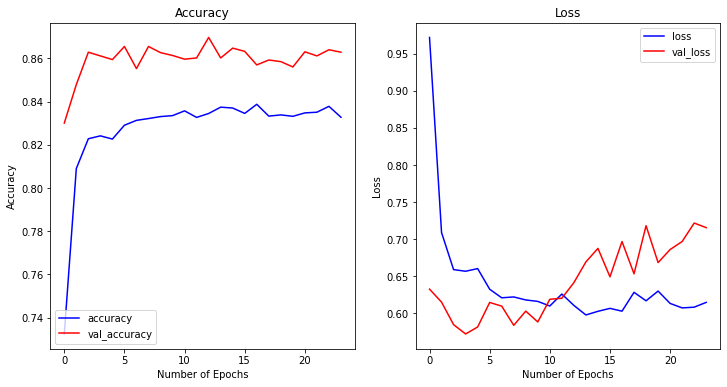

In [103]:
plot_history(history_1)

### Model 02

In [84]:
params_2 = {
    'dropout': (0.8),
    'filters': (256),
    'kernel_size': (7),
    'strides': (1),
    'pooling': GlobalMaxPooling1D(),  # MaxPool1D(), AveragePooling1D(), 
    'hidden_dims': (128),
    'learning_rate': (0.01),
    'batch_size': (128),
    'optimizer': ('SGD'),
    'epochs': 100,
    'verbose': 1,
    'patience': 20
}

In [85]:
history_2, model_2 = train_model(X_train, y_train, X_val, y_val, params_2)

Epoch 1/100
371/371 [==============================] - 2s 5ms/step - loss: 3.2562 - accuracy: 0.3002 - val_loss: 2.6946 - val_accuracy: 0.3572
Epoch 2/100
371/371 [==============================] - 2s 4ms/step - loss: 2.4293 - accuracy: 0.3562 - val_loss: 2.3775 - val_accuracy: 0.3572
Epoch 3/100
371/371 [==============================] - 2s 4ms/step - loss: 2.2580 - accuracy: 0.3970 - val_loss: 2.2683 - val_accuracy: 0.3633
Epoch 4/100
371/371 [==============================] - 2s 4ms/step - loss: 2.1571 - accuracy: 0.4263 - val_loss: 2.1775 - val_accuracy: 0.4173
Epoch 5/100
371/371 [==============================] - 2s 4ms/step - loss: 2.0832 - accuracy: 0.4452 - val_loss: 2.1242 - val_accuracy: 0.4269
Epoch 6/100
371/371 [==============================] - 2s 4ms/step - loss: 2.0286 - accuracy: 0.4573 - val_loss: 2.0831 - val_accuracy: 0.4626
Epoch 7/100
371/371 [==============================] - 2s 4ms/step - loss: 1.9862 - accuracy: 0.4681 - val_loss: 2.0343 - val_accuracy: 0.4883

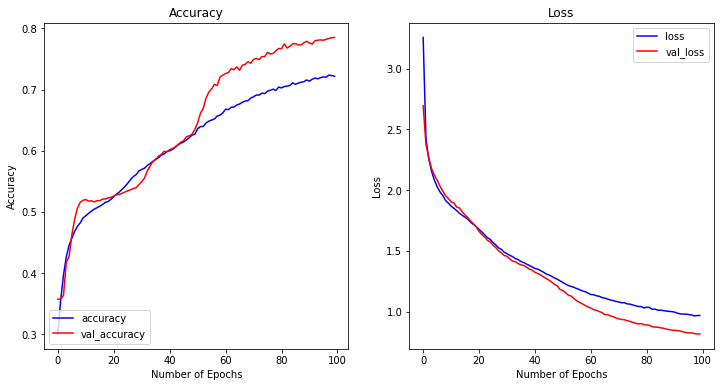

In [104]:
plot_history(history_2)

### Model 3

In [96]:
params_3 = {
    'dropout': (0.1),
    'filters': (512),
    'kernel_size': (3),
    'strides': (2),
    'pooling': GlobalMaxPooling1D(),  # MaxPool1D(), AveragePooling1D(), 
    'hidden_dims': (128),
    'learning_rate': (0.01),
    'batch_size': (64),
    'optimizer': ('adam'),
    'epochs': 100,
    'verbose': 1,
    'patience': 20
}

In [97]:
history_3, model_3 = train_model(X_train, y_train, X_val, y_val, params_3)

Epoch 1/100
742/742 [==============================] - 3s 4ms/step - loss: 0.6995 - accuracy: 0.8104 - val_loss: 0.5814 - val_accuracy: 0.8537
Epoch 2/100
742/742 [==============================] - 3s 4ms/step - loss: 0.5297 - accuracy: 0.8586 - val_loss: 0.5591 - val_accuracy: 0.8482
Epoch 3/100
742/742 [==============================] - 3s 4ms/step - loss: 0.4918 - accuracy: 0.8641 - val_loss: 0.5396 - val_accuracy: 0.8689
Epoch 4/100
742/742 [==============================] - 3s 4ms/step - loss: 0.4820 - accuracy: 0.8655 - val_loss: 0.6054 - val_accuracy: 0.8681
Epoch 5/100
742/742 [==============================] - 3s 4ms/step - loss: 0.4821 - accuracy: 0.8706 - val_loss: 0.6227 - val_accuracy: 0.8698
Epoch 6/100
742/742 [==============================] - 3s 4ms/step - loss: 0.4696 - accuracy: 0.8710 - val_loss: 0.5686 - val_accuracy: 0.8723
Epoch 7/100
742/742 [==============================] - 3s 4ms/step - loss: 0.4680 - accuracy: 0.8713 - val_loss: 0.5767 - val_accuracy: 0.8711

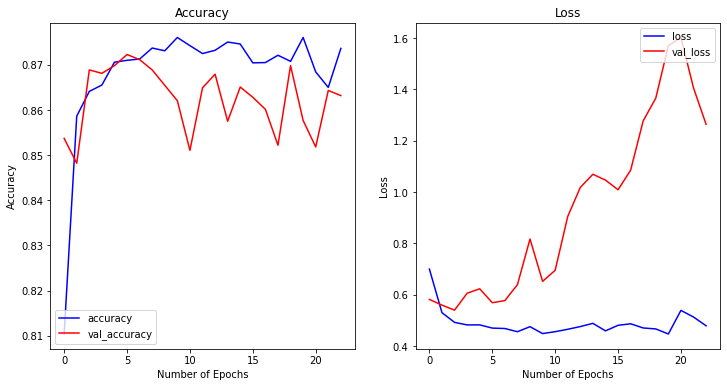

In [105]:
plot_history(history_3)

### Model 4

In [113]:
params_4 = {
    'dropout': (0.5),
    'filters': (128),
    'kernel_size': (5),
    'strides': (1),
    'pooling': GlobalMaxPooling1D(),  # MaxPool1D(), AveragePooling1D(), 
    'hidden_dims': (256),
    'learning_rate': (0.01),
    'batch_size': (64),
    'optimizer': ('adam'),
    'epochs': 100,
    'verbose': 1,
    'patience': 20
}

In [114]:
history_4, model_4 = train_model(X_train, y_train, X_val, y_val, params_4)

Epoch 1/100
742/742 [==============================] - 4s 4ms/step - loss: 0.9525 - accuracy: 0.7413 - val_loss: 0.6829 - val_accuracy: 0.8175
Epoch 2/100
742/742 [==============================] - 3s 4ms/step - loss: 0.7894 - accuracy: 0.7943 - val_loss: 0.6708 - val_accuracy: 0.8382
Epoch 3/100
742/742 [==============================] - 3s 3ms/step - loss: 0.7732 - accuracy: 0.8022 - val_loss: 0.6565 - val_accuracy: 0.8562
Epoch 4/100
742/742 [==============================] - 3s 3ms/step - loss: 0.7583 - accuracy: 0.8080 - val_loss: 0.6778 - val_accuracy: 0.8429
Epoch 5/100
742/742 [==============================] - 3s 3ms/step - loss: 0.7346 - accuracy: 0.8107 - val_loss: 0.6907 - val_accuracy: 0.8533
Epoch 6/100
742/742 [==============================] - 3s 3ms/step - loss: 0.7208 - accuracy: 0.8135 - val_loss: 0.6945 - val_accuracy: 0.8613
Epoch 7/100
742/742 [==============================] - 3s 3ms/step - loss: 0.7131 - accuracy: 0.8153 - val_loss: 0.6680 - val_accuracy: 0.8503

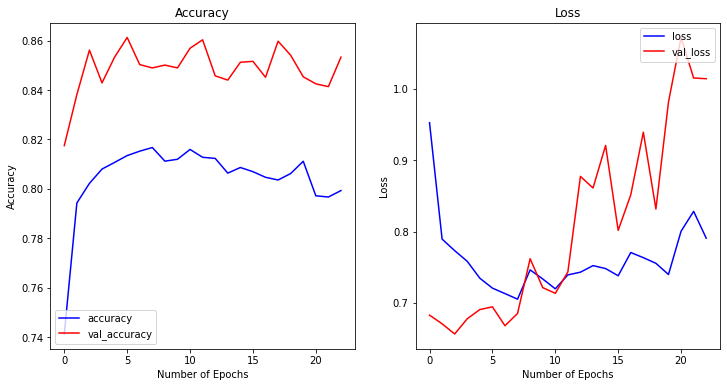

In [115]:
plot_history(history_4)

### Model 5

In [109]:
params_5 = {
    'dropout': (0.5),
    'filters': (512),
    'kernel_size': (5),
    'strides': (1),
    'pooling': GlobalMaxPooling1D(),  # MaxPool1D(), AveragePooling1D(), 
    'hidden_dims': (256),
    'learning_rate': (0.01),
    'batch_size': (100),
    'optimizer': ('adam'),
    'epochs': 100,
    'verbose': 1,
    'patience': 20
}

In [110]:
history_5, model_5 = train_model(X_train, y_train, X_val, y_val, params_5)

Epoch 1/100
475/475 [==============================] - 3s 6ms/step - loss: 0.8915 - accuracy: 0.7570 - val_loss: 0.5520 - val_accuracy: 0.8628
Epoch 2/100
475/475 [==============================] - 3s 5ms/step - loss: 0.7062 - accuracy: 0.8193 - val_loss: 0.5468 - val_accuracy: 0.8675
Epoch 3/100
475/475 [==============================] - 3s 5ms/step - loss: 0.6557 - accuracy: 0.8301 - val_loss: 0.5655 - val_accuracy: 0.8689
Epoch 4/100
475/475 [==============================] - 3s 5ms/step - loss: 0.6464 - accuracy: 0.8363 - val_loss: 0.5569 - val_accuracy: 0.8687
Epoch 5/100
475/475 [==============================] - 3s 5ms/step - loss: 0.6452 - accuracy: 0.8338 - val_loss: 0.5957 - val_accuracy: 0.8600
Epoch 6/100
475/475 [==============================] - 3s 5ms/step - loss: 0.6634 - accuracy: 0.8312 - val_loss: 0.6137 - val_accuracy: 0.8598
Epoch 7/100
475/475 [==============================] - 3s 5ms/step - loss: 0.6440 - accuracy: 0.8350 - val_loss: 0.6202 - val_accuracy: 0.8598

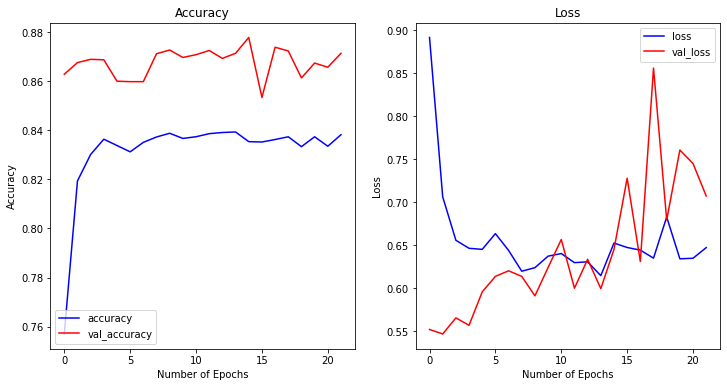

In [112]:
plot_history(history_5)

## Accuracy of the model

In [ ]:
accuracy_score(predicted_list.argmax(axis=1), test_classes_categorical.argmax(axis=1))

0.9195712523133868

### Confusion Matrix

In [ ]:
label_dict = pd.Series(df_test.label.values,index=df_test.label_index).to_dict()

test_list = test_classes_categorical.argmax(axis=1)
predicted_list = predicted_list.argmax(axis=1)
test_list_label = [label_dict[x] for x in test_list]
predicted_list_label = [label_dict[x] for x in predicted_list]

In [ ]:
confusion_matrix_final = confusion_matrix(test_list_label, predicted_list_label)

In [ ]:
confusion_matrix_dataframe = pd.DataFrame(confusion_matrix_final)
confusion_matrix_dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,528,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,42,0,2,0,2,0,0,0,0,...,0,2,0,0,0,0,0,0,0,2
2,0,0,9,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,4616,15,11,0,13,3,3,...,0,5,0,1,1,0,1,0,0,88
4,0,0,0,15,1403,11,0,3,4,0,...,0,0,0,8,0,0,0,0,1,31


In [ ]:
confusion_matrix_dataframe.reset_index(inplace=True)
confusion_matrix_dataframe.head()

,index,0,1,2,3,4,5,6,7,8,...,11,12,13,14,15,16,17,18,19,20
0,0,528,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1,0,42,0,2,0,2,0,0,0,...,0,2,0,0,0,0,0,0,0,2
2,2,0,0,9,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,3,0,0,0,4616,15,11,0,13,3,...,0,5,0,1,1,0,1,0,0,88
4,4,0,0,0,15,1403,11,0,3,4,...,0,0,0,8,0,0,0,0,1,31


In [ ]:
confusion_matrix_dataframe= confusion_matrix_dataframe.replace({"index": label_dict})
confusion_matrix_dataframe = confusion_matrix_dataframe.set_index('index')

In [ ]:
confusion_matrix_dataframe.columns = [label_dict[x] for x in confusion_matrix_dataframe.columns]

In [ ]:
confusion_matrix_dataframe

,ar,de,el,en,es,fr,he,id,it,ja,...,ms,nl,pl,pt,ru,sv,th,tl,tr,und
index,,,,,,,,,,,,,,,,,,,,,
ar,528,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
de,0,42,0,2,0,2,0,0,0,0,...,0,2,0,0,0,0,0,0,0,2
el,0,0,9,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
en,0,0,0,4616,15,11,0,13,3,3,...,0,5,0,1,1,0,1,0,0,88
es,0,0,0,15,1403,11,0,3,4,0,...,0,0,0,8,0,0,0,0,1,31
fr,0,0,0,14,5,196,0,1,0,0,...,0,2,0,0,0,0,0,0,0,6
he,0,0,0,0,0,0,13,0,0,0,...,0,0,0,0,0,0,0,0,0,1
id,0,0,0,24,2,4,0,730,0,1,...,7,2,0,1,0,0,1,5,0,39
it,0,0,0,2,6,1,0,0,63,0,...,0,0,0,1,0,0,0,0,0,3


### Heatmap for Confusion matrix

In [ ]:
import seaborn as sn

<AxesSubplot:ylabel='index'>

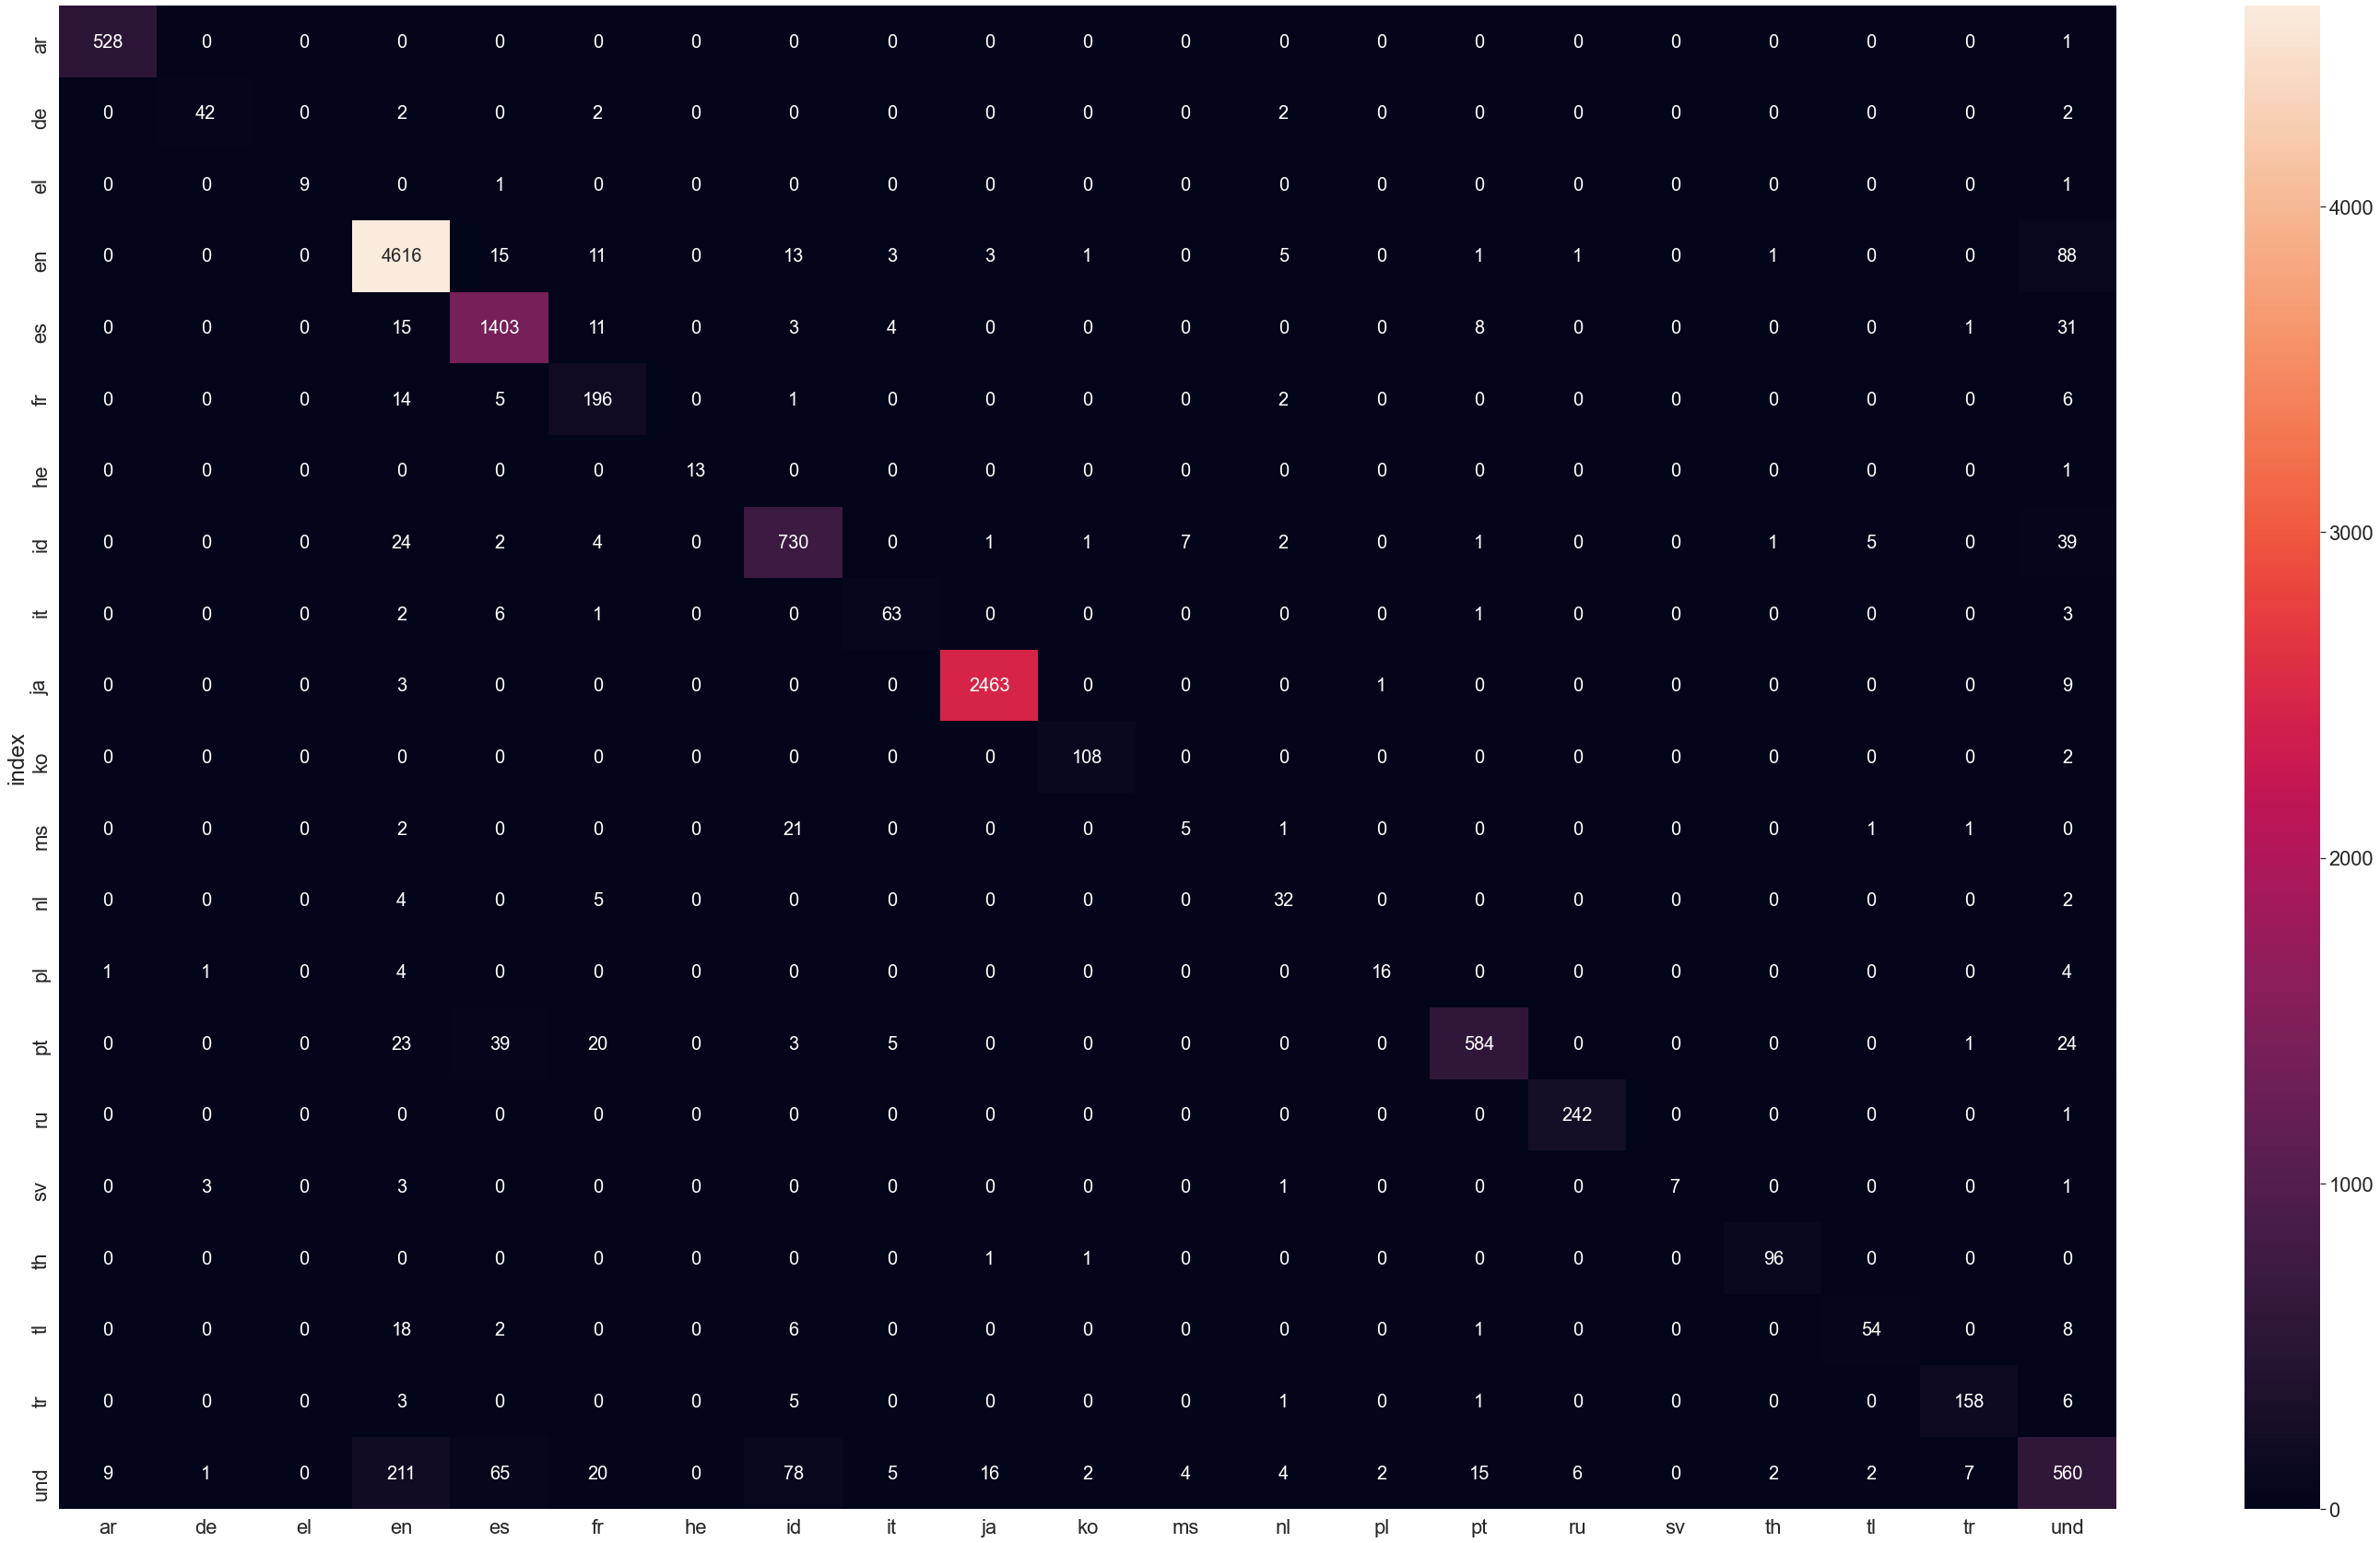

In [ ]:
plt.figure(figsize = (50, 30))
sn.set(font_scale=2) 
sn.heatmap(confusion_matrix_dataframe, annot=True, annot_kws={"size": 20}, fmt='.4g')

## Plotting correlation between Hyperparameters from Talos dataframe

##### Creating a dataframe from talos object and filtering hyperaparameter subset from it

In [ ]:
params_df = t.data
params_df = params_df[['batch_size','dropout', 'filters','hidden_dims', 'kernel_size', 'learning_rate','optimizer','pooling','strides']]

In [ ]:
# changing pooling to a single value since only 1 pooling type used in Talos Scan
params_df['pooling'] = 1

In [ ]:
# function to replace values in the optimizer column with indexes
def replace_optim(x):
  if x == 'Adam':
    return 0
  else:
    return 1

In [ ]:
# applying function to change values of optimizer to indexes and dropping old optimizer column
params_df['optimizer_num'] = params_df['optimizer'].apply(replace_optim)
params_df.drop(columns='optimizer', inplace=True, axis=1)

<AxesSubplot:>

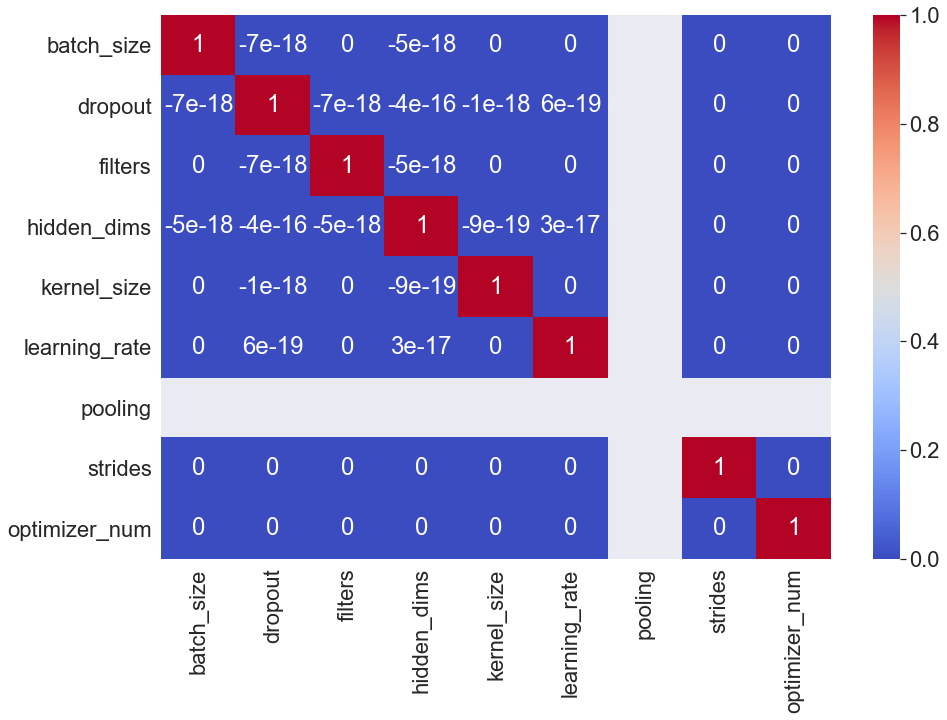

In [ ]:
# plotting correlation plot for hyperparameters
plt.rcParams['figure.figsize'] = (15.0, 10.0)
sn.heatmap(params_df.corr(), annot = True,cmap= 'coolwarm', fmt='.1g')